# Benchmarking perturbation modelling tools - scGen
---
---

## 1. Introduction

In this notebook, we focus on two experiments with **scGen**:
1. **How data imbalance affects scGen**
   *We manually thin the Kang 2018 dataset so that only 20 % of the IFN-β cells remain, retrain scGen, and benchmark it against the original balanced model.*
   You’ll see which headline metrics hold up (R², Pearson) and which subtle ones deteriorate (MSE, Energy- & KDE distance)—a concrete lesson on why class imbalance matters in single-cell perturbation studies.

2. **How key hyper-parameters steer performance**
   *With the balanced data we run a mini grid-search: network depth (1 vs 3 layers) × dropout (0.05 vs 0.30).*
   Four quick trainings, side-by-side PCAs and metric bar-plots show the trade-off between model capacity and regularisation—no Optuna deep-dive needed.

By the end you’ll know **how to probe scGen’s robustness to dataset quirks and to your own modelling choices**; skills you can port to any perturbation model or new dataset.


---

## 2. Environment Setup & Imports

In [1]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)
import warnings           # warning control (e.g. to suppress scVI warnings)
warnings.filterwarnings('ignore')  # suppress warnings (e.g. from scVI or scanpy)

# --- Numerical & data-handling stack -------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from pandas.api.types import CategoricalDtype  # categorical data types
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics

# --- Single-cell analysis ecosystem --------------------------------------------
import scanpy as sc       # core single-cell workflow (AnnData, QC, plotting)
from scanpy.pl import DotPlot # dot plots for visualising gene expression
import anndata            # core data structure for single-cell data (AnnData)
import pertpy as pt       # Perturb-Bench helpers: dataset loaders & metrics
from pertpy.tools import Distance  # distance metrics for single-cell data
import scvi               # single-cell variational inference (scVI) for deep learning
from scvi import REGISTRY_KEYS  # keys used by scvi-tools / scGen for AnnData metadata

# --- Deep-learning backend -----------------------------------------------------
import torch                    # PyTorch (Tensor operations and GPU acceleration)
import pytorch_lightning as pl  # PyTorch Lightning (high-level training framework)

# --- Machine-learning utilities ------------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import r2_score                 # R-squared metric
import itertools                                     # combinatorial operations

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # base plotting library
import matplotlib as mpl         # base matplotlib library
from matplotlib.gridspec import GridSpec # flexible grid layout for subplots
import seaborn as sns            # higher-level statistical plots

# --- Device & runtime configuration --------------------------------------------
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"Running on {'GPU' if cuda_available else 'CPU'} – "
      f"{torch.cuda.get_device_name(0) if cuda_available else 'no CUDA device'}")

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True   # exact determinism (may reduce speed)
torch.backends.cudnn.benchmark = False
pl.seed_everything(SEED, workers=True)
scvi.settings.seed = SEED 

print(f"Random seed set to {SEED}")

Seed set to 42
Seed set to 42


Running on CPU – no CUDA device
Random seed set to 42


---

## 3. Training scGen on an imbalanced dataset

Real single-cell perturbation studies are rarely as tidy as the original *Kang 2018* PBMC benchmark:

* **Unequal sequencing budgets:** Often the *control* arm is run on many more cells or lanes than the *stimulated* arm.
* **Cell-type–specific dropout:** Fragile or rare lineages (e.g. pDCs, dendritic cells) tend to die or fail library prep more frequently in one condition.
* **Down-sampling during integration:** Pipelines sometimes subsample the larger condition to match the smaller one, throwing away useful signal.

To stress-test our models under such realistic constraints we built a **globally imbalanced clone of *Kang 2018***:

| Design choice              | What we did                                                | Rationale                                                                                                     |
| -------------------------- | ---------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **Target ratio**           | kept only **20 %** of all *stimulated* cells               | mimics a 5× sequencing depth bias that is common in practice                                                  |
| **Per-cell-type sampling** | selected the 20 % *uniformly within each lineage*          | preserves the original cell-type composition so we can attribute metric changes purely to condition imbalance |

Do our models still achieve high R² and low E-distance when the minority condition is only one-fifth the size? Let's find out!

**Next steps:**
*We’ll load the imbalanced AnnData below, run the same exploration and preparation, then train and evaluate scGen exactly as before so the comparison is apples-to-apples.*


In [2]:
adata_imb = sc.read('../data/kang_2018_imbalanced.h5ad') # loading the data directly from the file

adata_imb.obs.rename(columns={"label": "condition"}, inplace=True) # renaming the 'label' column to 'condition'

# Renaming the categories in the 'condition' column
if isinstance(adata_imb.obs["condition"].dtype, CategoricalDtype):
    adata_imb.obs["condition"] = (
        adata_imb.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata_imb.obs["condition"] = (
        adata_imb.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )

adata_imb # viewing the data

AnnData object with n_obs × n_vars = 14778 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'condition'
    var: 'name'
    uns: 'condition_colors'
    obsm: 'X_pca', 'X_umap'

In [3]:
# Displaying the counts of cells per condition and cell type
counts = (adata_imb.obs
               .groupby(["cell_type", "condition"])
               .size()
               .unstack(fill_value=0)
               .sort_index())
display(counts)

/tmp/ipykernel_333410/3035611922.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cell_type", "condition"])


condition,control,stimulated
cell_type,,
CD4 T cells,5560,1130
CD14+ Monocytes,2932,533
B cells,1316,267
NK cells,855,177
CD8 T cells,811,161
FCGR3A+ Monocytes,520,130
Dendritic cells,258,51
Megakaryocytes,63,14


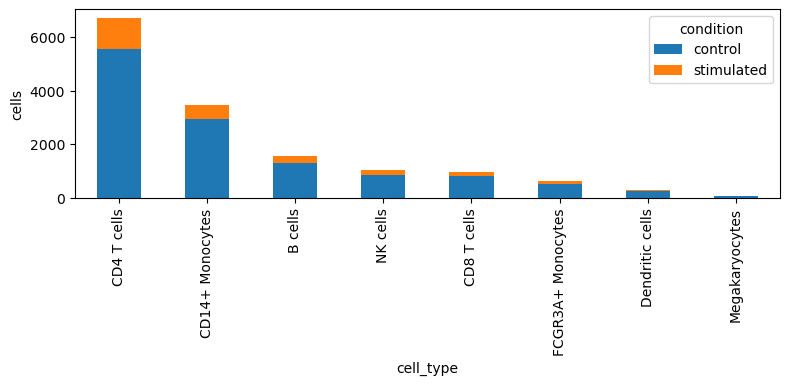

In [4]:
# Bar plot: cells per type × condition
count_df = (adata_imb.obs.groupby(['cell_type','condition'], observed=True)['condition']
            .count().unstack().fillna(0))
count_df.plot.bar(stacked=True, figsize=(8,4))
plt.ylabel('cells'); plt.tight_layout(); plt.show()

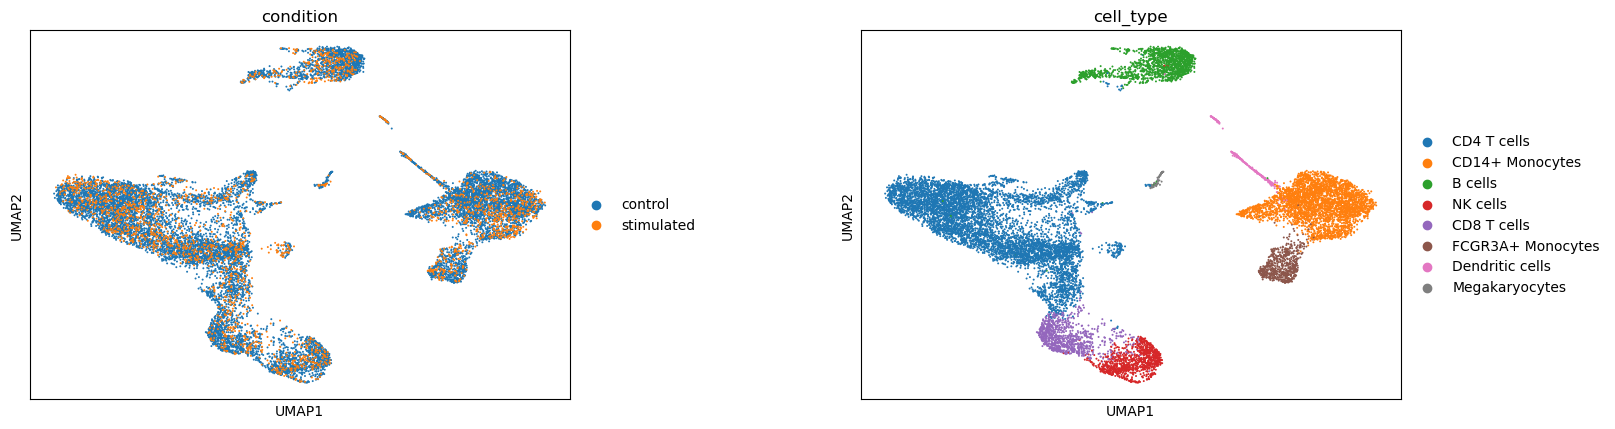

In [5]:
# UMAP visualization of the imbalanced dataset
sc.pl.umap(adata_imb, color=['condition','cell_type'], wspace=0.4)

We perform the same data preparation steps as before, but this time we use the imbalanced dataset.

```python

In [6]:
sc.pp.filter_genes(adata_imb, min_cells=3) # filtering genes expressed in at least 3 cells
sc.pp.normalize_total(adata_imb, target_sum=1e4) # normalizing total counts per cell to 10,000
sc.pp.log1p(adata_imb) # log-transforming the data (log1p = log(x + 1))
sc.pp.highly_variable_genes(adata_imb, flavor='seurat', n_top_genes=2000, subset=True) # selecting the top 2000 highly variable genes

adata_imb # viewing the processed imbalanced data

AnnData object with n_obs × n_vars = 14778 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'condition'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

We then train scGen on the imbalanced dataset, using the same parameters as before.

In [8]:
# Creating a training set by excluding 'stimulated' cells of the specified cell type (CD4 T cells in this case)
celltype_to_train = 'CD4 T cells'

# Filtering the AnnData object to create a training set
train_adata = adata_imb[~(
    (adata_imb.obs['cell_type'] == celltype_to_train) &
    (adata_imb.obs['condition'] == 'stimulated')
)].copy()

pt.tl.Scgen.setup_anndata(train_adata, batch_key='condition', labels_key='cell_type') # Setting up the AnnData object for scGen with batch and labels keys
# scGen uses 'condition' as the batch key and 'cell_type' as the labels key.
# This means that scGen will learn to generate data conditioned on the 'condition' (batch) and will use 'cell_type' as the labels for the generated data.
model = pt.tl.Scgen(train_adata) # Initializing the scGen model with the training data
# Training the scGen model with early stopping (to prevent overfitting) and GPU acceleration if available
# The model will train for a maximum of 10 epochs with a batch size of 32.
model.train(max_epochs=10, batch_size=32,
            early_stopping=True,
            accelerator=('gpu' if cuda_available else 'cpu'),
            devices=1)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Predicting the 'stimulated' condition for the specified cell type (CD4 T cells in this case)
pred, _ = model.predict(ctrl_key='control', stim_key='stimulated',
                        celltype_to_predict=celltype_to_train)
pred.obs['condition'] = 'predicted' # Setting the condition of the predicted data to 'predicted'

ctrl = adata_imb[(adata_imb.obs['cell_type']==celltype_to_train)&(adata_imb.obs['condition']=='control')] # Filtering the AnnData object to create a control set for the specified cell type (CD4 T cells in this case)
stim = adata_imb[(adata_imb.obs['cell_type']==celltype_to_train)&(adata_imb.obs['condition']=='stimulated')] # Filtering the AnnData object to create a stimulated set for the specified cell type (CD4 T cells in this case)

eval_ad_imb = anndata.concat([ctrl, stim, pred]) # Concatenating the control, stimulated, and predicted data into a single AnnData object for evaluation
eval_ad_imb.obs_names_make_unique() # Ensuring that the observation names are unique in the concatenated AnnData object
sc.tl.pca(eval_ad_imb, n_comps=30, svd_solver='arpack') # Performing PCA on the concatenated AnnData object to reduce dimensionality

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [10]:
# Displaying the counts of cells per condition and cell type for the concatenated AnnData object
counts_pred = (eval_ad_imb.obs
               .groupby(["cell_type", "condition"])
               .size()
               .unstack(fill_value=0)
               .sort_index())
display(counts_pred)

condition,control,predicted,stimulated
cell_type,,,
CD4 T cells,5560,5560,1130


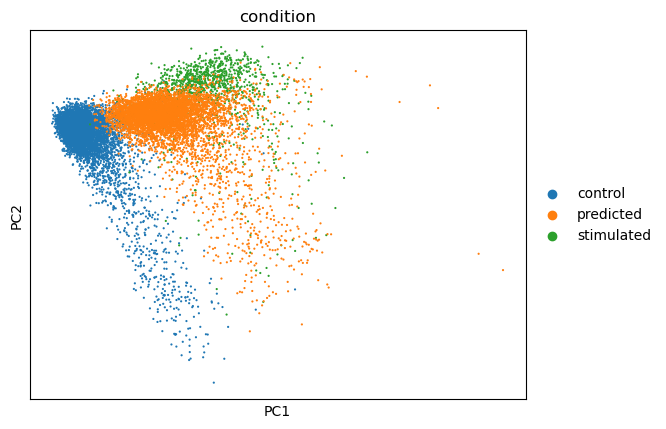

In [11]:
sc.pl.pca(eval_ad_imb, color=['condition']) # Plotting PCA results colored by condition

We can then evaluate the model on the imbalanced dataset.

In [2]:
# Helper functions

def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    """
    Compute the L1 (Manhattan) distance between mean-variance KDEs.
    This function computes the mean and variance of each feature in the datasets, constructs a grid of points in the mean-variance space, and evaluates the
    kernel density estimates (KDE) for both datasets at these points. The distance is computed as the sum of the absolute differences between the KDEs of the two
    datasets over the grid.
    If either dataset has no valid points (e.g., all NaNs), the function returns NaN.
    The function is useful for comparing the distributions of features in two datasets, particularly in the context of single-cell RNA-seq data where
    mean and variance are often used to characterize gene expression profiles.
    """        
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.column_stack([m1,v1]), np.column_stack([m2,v2])
    ok = ~(np.isnan(pts1).any(1)|np.isnan(pts2).any(1))
    pts1, pts2 = pts1[ok], pts2[ok]
    if pts1.size==0 or pts2.size==0:
        return np.nan
    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.column_stack(np.meshgrid(xs, ys)).reshape(-1,2)
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1-d2).sum()*dx*dy)

def bootstrap_metrics(X, real_mask, pred_mask, pca, n_boot=100, frac=0.8, seed=SEED):
    """
    Bootstrap metrics for evaluating the performance of a model.
    This function computes the R2, MSE, and Pearson correlation coefficients between the predicted and real data.
    It uses bootstrapping to estimate the variability of these metrics.
    """
    rng = np.random.default_rng(seed)
    r_idx, p_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
    if len(r_idx)==0 or len(p_idx)==0:
        return {k:np.nan for k in ['R2','MSE','Pearson']}
    s_r, s_p = int(frac*len(r_idx)), int(frac*len(p_idx))
    vals = {'R2':[], 'MSE':[], 'Pearson':[]}
    for _ in range(n_boot):
        r = rng.choice(r_idx, s_r, replace=True)
        p = rng.choice(p_idx, s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d = Xp - Y
        vals['MSE'].append(np.mean(d**2))
        ss_res = ((Y - Xp)**2).sum(); ss_tot = ((Y - Y.mean())**2).sum()
        vals['R2'].append(1-ss_res/ss_tot if ss_tot>0 else np.nan)
        vals['Pearson'].append(stats.pearsonr(Xp, Y)[0])
    return {k:np.nanmean(v) for k,v in vals.items()}

In [ ]:
# Computing metrics for the predicted data against the stimulated data
X = eval_ad_imb.X.toarray() if sparse.issparse(eval_ad_imb.X) else eval_ad_imb.X # Converting the data to a dense array if it is sparse
ctrl_m = eval_ad_imb.obs['condition']=='control' # Creating a mask for the control condition
stim_m = eval_ad_imb.obs['condition']=='stimulated' # Creating a mask for the stimulated condition
pred_m = eval_ad_imb.obs['condition']=='predicted' # Creating a mask for the predicted condition

# R^2, MSE, and Pearson correlation coefficients calculation
boot = bootstrap_metrics(X, stim_m, pred_m, eval_ad_imb.obsm['X_pca']) # Bootstrapping metrics for the predicted data against the stimulated data

# Energy distance calculation
e_dist = Distance("edistance").pairwise(
            eval_ad_imb[eval_ad_imb.obs["condition"].isin(["predicted","stimulated"])],
            groupby="condition"
         ).loc["predicted", "stimulated"] # Computing the energy distance between the predicted and stimulated data

# Mean-variance KDE distance calculation
mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m]) # Computing the mean-variance KDE distance between the stimulated and predicted data

# Top 100 DEG Jaccard index calculation
sc.tl.rank_genes_groups(eval_ad_imb, groupby='condition', reference='control',
                        groups=['stimulated','predicted'], method='wilcoxon', n_genes=eval_ad_imb.n_vars) # Ranking genes for the stimulated and predicted conditions against the control condition
true_top = eval_ad_imb.uns['rank_genes_groups']['names']['stimulated'][:100] # Getting the top 100 genes for the stimulated condition
pred_top = eval_ad_imb.uns['rank_genes_groups']['names']['predicted'][:100] # Getting the top 100 genes for the predicted condition
shared = set(true_top)&set(pred_top) # Finding the shared top genes between the stimulated and predicted conditions
jaccard = len(shared)/(200-len(shared)) # Computing the Jaccard index for the shared top genes

Output()

In [13]:
# Creating a DataFrame to store the results
results_df = pd.DataFrame([{
    'cell_type'      : 'CD4 T cells',
    'gene_set'       : 'CD4 default',
    **boot,
    'e_distance'     : e_dist,
    'mv_kde'         : mv_kde,
    'jaccard_top100' : jaccard
}])

results_df # Displaying the results DataFrame with the computed metrics

,cell_type,gene_set,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100
0,CD4 T cells,CD4 default,0.926275,0.01058,0.965113,3.006744,0.033682,0.123596


In [14]:
results_df.to_csv("../data/scGen_metrics_CD4_default_imbalaced.tsv", sep="\t", index=False) # Saving the results DataFrame to a TSV file for further analysis

We can compare scGen's performance on the imbalanced dataset with its performance on the original balanced dataset.

In [15]:
results_df_original = pd.read_csv("../data/scGen_metrics_CD4_default.tsv", sep="\t") # Loading the original results DataFrame from the TSV file

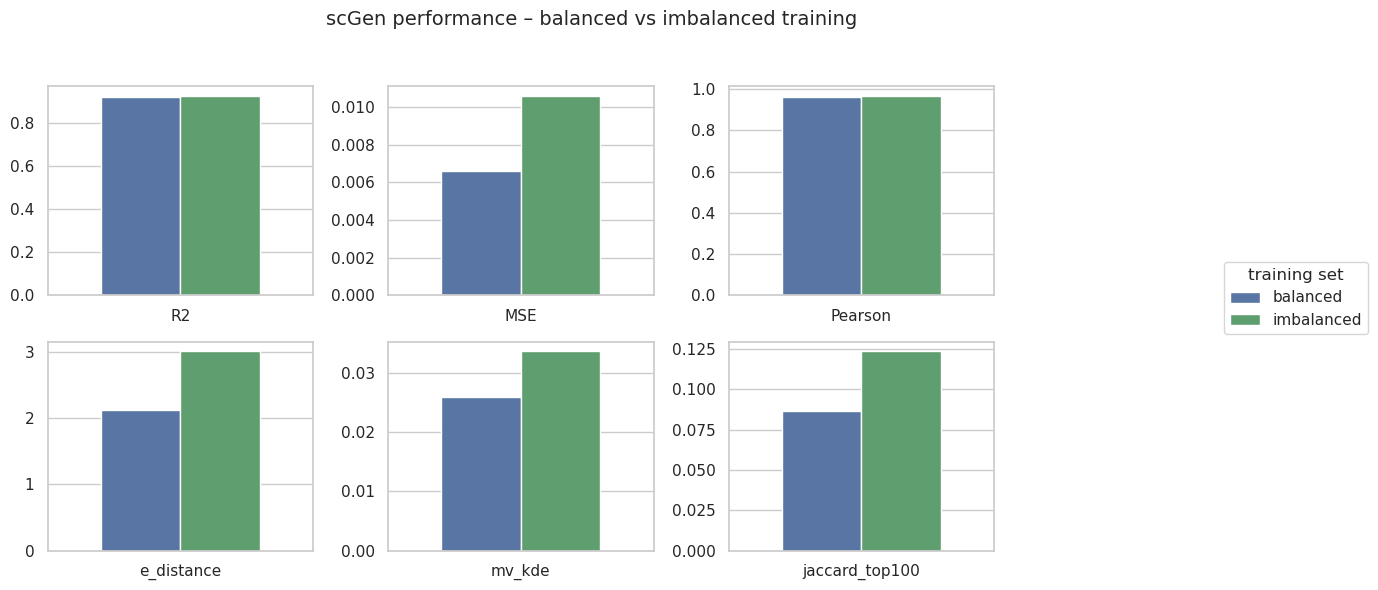

In [ ]:
# ╔═════════════════════════════════════════════════════════════════╗
# ║  Compare scGen on *balanced* vs *imbalanced* Kang 2018          ║
# ╚═════════════════════════════════════════════════════════════════╝

# ------------------------------------------------------------------
# 1) Merge the two summary tables into “long” format
# ------------------------------------------------------------------
metrics = ["R2", "MSE", "Pearson", "e_distance", "mv_kde", "jaccard_top100"]

df_bal   = results_df_original.copy()  # ← already a 1-row dataframe
df_bal["dataset"] = "balanced"

df_imbal          = results_df.copy()
df_imbal["dataset"] = "imbalanced"

long_df = (pd.concat([df_bal, df_imbal], ignore_index=True)
             .melt(id_vars="dataset", value_vars=metrics,
                   var_name="metric", value_name="score"))

# ------------------------------------------------------------------
# 2) Facet-style bar-plots: one subplot per metric
# ------------------------------------------------------------------
sns.set(style="whitegrid")
ncols = 3
fig, axes = plt.subplots(2, ncols, figsize=(12, 6), sharey=False)
axes = axes.ravel()

palette = {"balanced": "#4C72B0", "imbalanced": "#55A868"}

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data   = long_df[long_df["metric"] == metric],
        x      = "metric",          # dummy axis (one tick → metric name)
        y      = "score",
        hue    = "dataset",
        dodge  = True,
        palette= palette,
        width  = .6,
        ax     = ax,
    )
    ax.set_xlabel("")              # no redundant label
    ax.set_ylabel("")              # keep plot clean
    ax.tick_params(axis="x", rotation=0)

# single legend outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="training set",
           bbox_to_anchor=(1.02, 0.5), loc="center left")
for ax in axes: ax.get_legend().remove()      # drop duplicate legends

fig.suptitle("scGen performance – balanced vs imbalanced training", fontsize=14)
fig.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


* **Bulk trend intact, details degraded:** R² and Pearson being almost identical for both models shows that scGen still learns the overall IFN-β shift even when 80 % of stimulated cells are removed, but the higher MSE, energy-distance and KDE distance reveal a loss of fine-grained accuracy.
* **Apparent Jaccard gain is misleading:** The imbalanced model overlaps more top-100 DEGs, yet this likely reflects over-fitting to the strongest ISGs (Interferon-Stimulated Genes), and the fact we analyse only the 2,000 HVGs; other quantitative metrics clearly worsen.
* **Practical takeaway:** Moderate condition imbalance is tolerable for broad pathway-level insights, but a balanced dataset is preferable when you need distribution-level realism or precise gene-level effect sizes.

---

## 4. scGen Hyperparameter Optimization with Optuna

Machine-learning models come with **hyper-parameters** – dials the user sets *before* training begins:
* network architecture (layer depth, latent dimensionality, hidden width)
* optimisation strategy (learning-rate, batch-size, weight-decay)
* regularisation (drop-out, KL-weight, early-stopping patience)

Choosing them well can **shrink training time**, **prevent over- or under-fitting** and ultimately **boost predictive accuracy**. Doing it by hand is tedious; instead we let **Optuna** (a lightweight
Bayesian-optimisation framework) explore the search-space for us.

[Optuna](https://github.com/optuna/optuna) treats training as a black-box **objective (trial) → score**:

1. **Suggest** a set of hyper-parameters
2. **Train** the model with those settings
3. **Evaluate** the objective (here: validation R²)
4. **Learn** from previous trials to pick the next, more promising hyper-parameters

> ⚡ In a real project you might run *hundreds* of trials.
> In a live workshop we want fast feedback, so we restrict the search to a
> **tiny 2 × 2 grid** that still illustrates the effect of each dial.

We load and prepare the original *Kang 2018* PBMC dataset, then run the hyperparameter optimisation for scGen.

In [3]:
adata = sc.read('../data/kang_2018.h5ad') # loading the data directly from the file

adata.obs.rename(columns={"label": "condition"}, inplace=True) # renaming the 'label' column to 'condition'

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype):
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )
    
sc.pp.filter_genes(adata, min_cells=3) # filtering genes expressed in at least 3 cells
sc.pp.normalize_total(adata, target_sum=1e4) # normalizing total counts per cell to 10,000
sc.pp.log1p(adata) # log-transforming the data (log1p = log(x + 1))
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, subset=True) # selecting the top 2000 highly variable genes

# Creating a training set by excluding 'stimulated' cells of the specified cell type (CD4 T cells in this case)
celltype_to_train = 'CD4 T cells'

# Filtering the AnnData object to create a training set
train_adata = adata[~(
    (adata.obs['cell_type'] == celltype_to_train) &
    (adata.obs['condition'] == 'stimulated')
)].copy()

**scGen’s main hyper-parameters:**

| Hyper-parameter     | Role in the model                               | Typical range | Default | Tuned here?       |
| ------------------- | ----------------------------------------------- | ------------- | ------- | ----------------- |
| **`n_hidden`**      | Width of each fully-connected layer (neurons)   | 64 – 512      | 128     | –                 |
| **`n_latent`**      | Dimensionality of the VAE latent space          | 8 – 128       | 32      | **fixed (32)**    |
| **`n_layers`**      | *Depth* – encoder & decoder MLP blocks          | 1 – 4         | 2       | **1 vs 3**        |
| **`dropout_rate`**  | Share of units randomly zero-ed during training | 0.0 – 0.4     | 0.1     | **0.05 vs 0.30**  |
| **`learning_rate`** | Adam optimiser step size                        | 1e-4 – 3e-3   | 1e-3    | fixed             |
| **`weight_decay`**  | L2 regularisation on weights                    | 1e-6 – 1e-3   | 1e-5    | fixed             |
| **`batch_size`**    | Minibatch size                                  | 32 – 256      | 32      | fixed             |
| **`kl_weight`**     | Scaling of KL term during warm-up               | 0.1 – 1.0     | 1.0     | fixed             |
| **`max_epochs`**    | Upper bound on training epochs                  | 10 – 400      | 10      | fixed (for speed) |

**Our mini-grid: depth × drop-out**
* **Network depth (`n_layers`):**
    * *1 layer* = almost linear auto-encoder – swift but limited capacity.
    * *3 layers* = adds extra non-linearities – can learn richer transformations but risks over-fitting on small datasets.
* **Drop-out:** Softly forces the network to rely on redundant representations.
    * Low (0.05) keeps most activations
    * High (0.30) injects strong noise.

Running all four combinations is enough to show clear performance trends **in the tutorial's timeframe**.

In [4]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║  Mini-sweep: 4 scGen models (2 × 2 hyper-parameter grid)         ║
# ╚══════════════════════════════════════════════════════════════════╝

# -------------------------------------------------------------------
# 0) grid definition  ▸ 4 combinations -------------------------------
# -------------------------------------------------------------------
layer_vals   = [1, 3]         # shallow vs deep
dropout_vals = [0.05, 0.30]   # light vs strong regularisation
grid         = list(itertools.product(layer_vals, dropout_vals))

# -------------------------------------------------------------------
# 1) containers to collect metrics + PCA snapshots -------------------
# -------------------------------------------------------------------
results, pca_snaps = [], []
start = time.time()

for n_layers, dropout in grid:
    label = f"l{n_layers}_do{dropout}"
    print(f"\n🔧 Training model {label}")

    # (a) build training set (hide real IFN-β CD4-T cells)
    train_adata = adata[~(
        (adata.obs["cell_type"] == "CD4 T cells") &
        (adata.obs["condition"] == "stimulated")
    )].copy()

    # (b) set-up + train
    pt.tl.Scgen.setup_anndata(train_adata,
                              batch_key="condition",
                              labels_key="cell_type")

    model = pt.tl.Scgen(
        train_adata,
        n_hidden     = 128,
        n_latent     = 32,
        n_layers     = n_layers,
        dropout_rate = dropout,
    )
    model.train(
        max_epochs     = 10,
        batch_size     = 32,
        early_stopping = True,
        accelerator    = ("gpu" if cuda_available else "cpu"),
        devices        = 1
    )

    # (c) predict held-out CD4-T stimulation
    pred, _ = model.predict("control", "stimulated",
                            celltype_to_predict="CD4 T cells")
    pred.obs["condition"] = "predicted"

    ctrl = adata[(adata.obs["cell_type"]=="CD4 T cells") &
                 (adata.obs["condition"]=="control")]
    stim = adata[(adata.obs["cell_type"]=="CD4 T cells") &
                 (adata.obs["condition"]=="stimulated")]
    eval_ad = anndata.concat([ctrl, stim, pred]); eval_ad.obs_names_make_unique()

    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
    pca_snaps.append((label, eval_ad.obsm["X_pca"],
                      eval_ad.obs["condition"].copy()))

    # (d) metrics
    X      = eval_ad.X.toarray() if sparse.issparse(eval_ad.X) else eval_ad.X
    stim_m = eval_ad.obs["condition"] == "stimulated"
    pred_m = eval_ad.obs["condition"] == "predicted"
    boot   = bootstrap_metrics(X, stim_m, pred_m, eval_ad.obsm["X_pca"])
    e_dist = Distance("edistance").pairwise(
                 eval_ad[eval_ad.obs["condition"].isin(
                     ["stimulated","predicted"])],
                 groupby="condition"
             ).loc["predicted","stimulated"]
    mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

    sc.tl.rank_genes_groups(
        eval_ad, groupby="condition", reference="control",
        groups=["stimulated", "predicted"], method="wilcoxon",
        n_genes=eval_ad.n_vars
    )
    t100 = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:100]
    p100 = eval_ad.uns["rank_genes_groups"]["names"]["predicted"][:100]
    jaccard = len(set(t100)&set(p100)) / (200 - len(set(t100)&set(p100)))

    results.append(dict(
        model       = label,
        R2          = boot["R2"],
        MSE         = boot["MSE"],
        Pearson     = boot["Pearson"],
        E_distance  = e_dist,
        MV_KDE      = mv_kde,
        Jaccard     = jaccard
    ))

print(f"\n✅  Finished {len(grid)} runs in {time.time()-start:.1f} s")

results_df = pd.DataFrame(results).set_index("model")
display(results_df.style.format("{:.3f}"))


🔧 Training model l1_do0.05
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Output()


🔧 Training model l1_do0.3
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Output()


🔧 Training model l3_do0.05
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Output()


🔧 Training model l3_do0.3
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Output()


✅  Finished 4 runs in 561.0 s


,R2,MSE,Pearson,E_distance,MV_KDE,Jaccard
model,,,,,,
l1_do0.05,0.956,0.004,0.980,1.772,0.030,0.087
l1_do0.3,0.930,0.006,0.965,2.722,0.032,0.070
l3_do0.05,0.931,0.006,0.966,2.140,0.026,0.026
l3_do0.3,0.867,0.011,0.934,5.243,0.029,0.026


We save the results to a file and then plot them.

In [6]:
results_df.to_csv("../data/scGen_metrics_CD4_optimized.tsv", sep="\t", index=True) # Saving the results DataFrame to a TSV file for further analysis

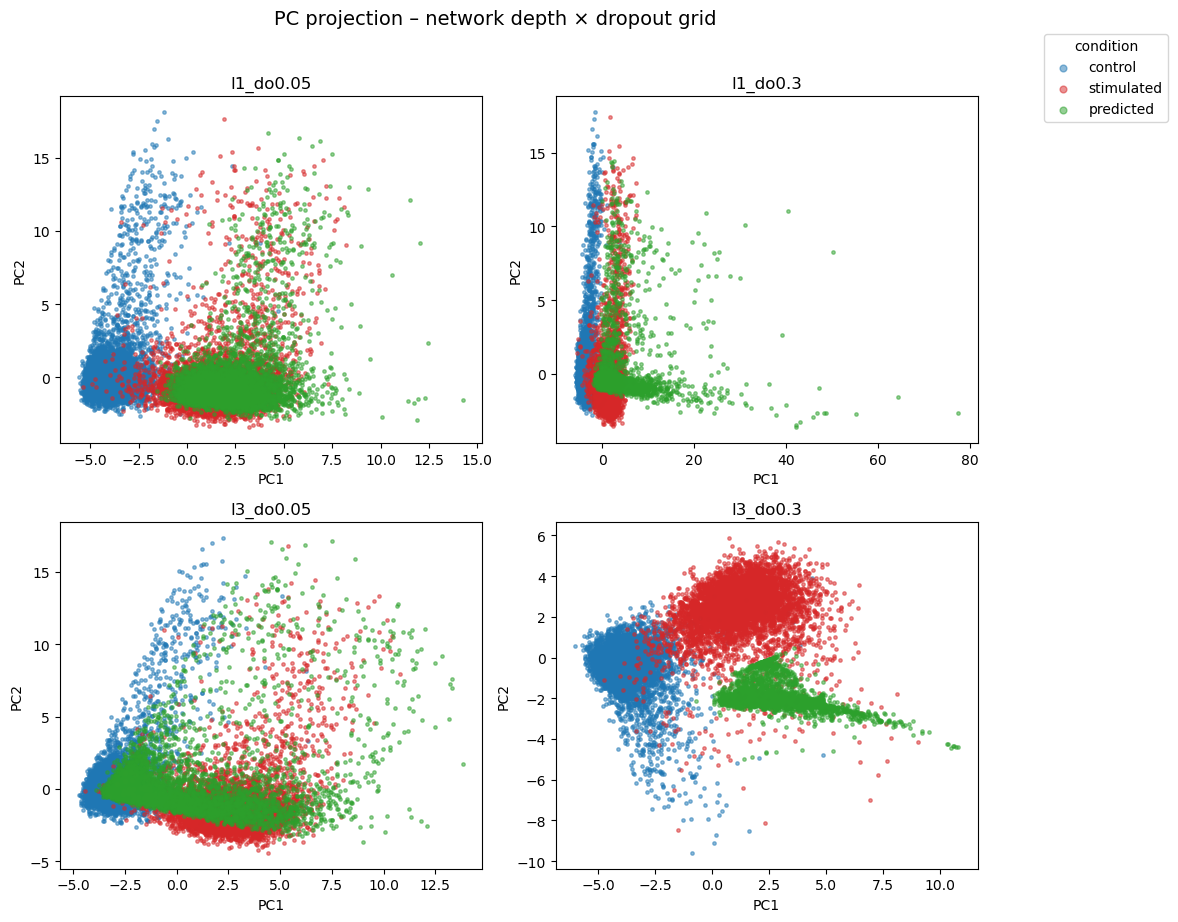

In [8]:
# 4 scatter-plots:   PC1 × PC2 for each model
fig = plt.figure(figsize=(10, 9))
gs  = GridSpec(2, 2, figure=fig, wspace=0.28, hspace=0.28)

for ax, (label, X_pca, cond) in zip(fig.subplots(2, 2).ravel(), pca_snaps):
    for c in ["control", "stimulated", "predicted"]:
        m = cond == c
        ax.scatter(X_pca[m,0], X_pca[m,1], s=6, alpha=0.5,
                   label=c if ax is fig.axes[0] else "", c=palette[c])
    ax.set_title(label); ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

fig.legend(loc="upper right", bbox_to_anchor=(1.18, 1.0),
           title="condition", markerscale=2)
fig.suptitle("PC projection – network depth × dropout grid", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()


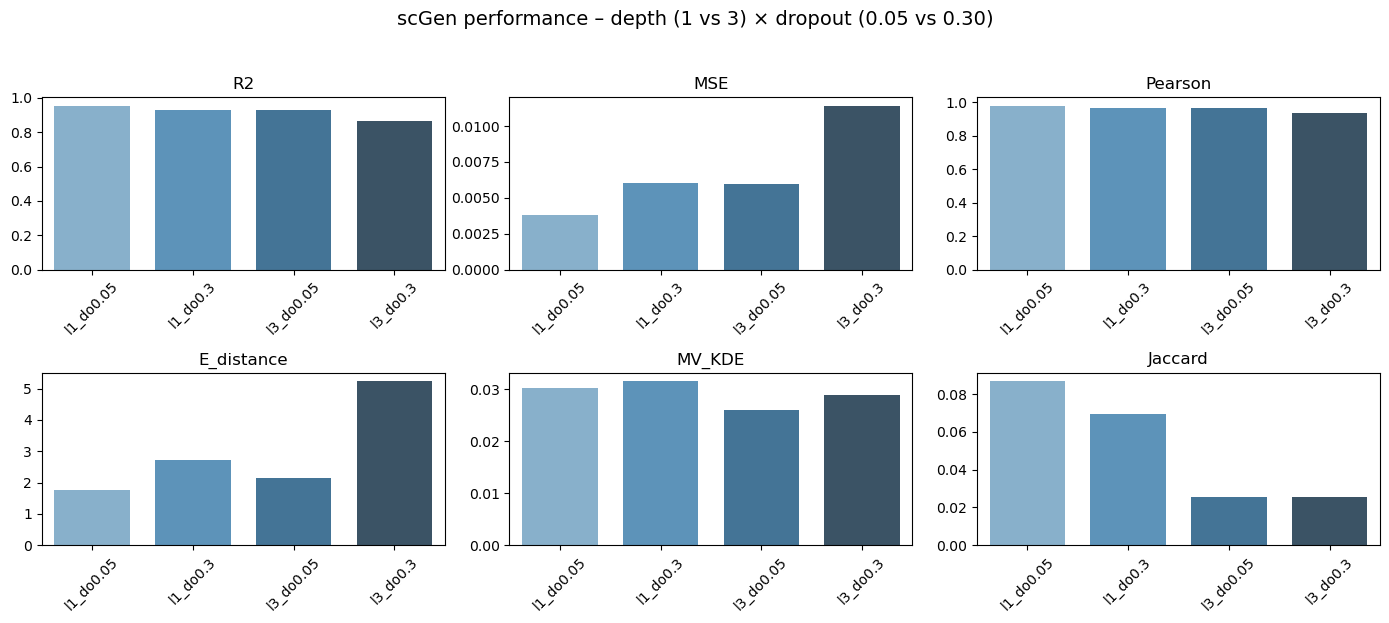

In [9]:
metrics = ["R2", "MSE", "Pearson", "E_distance", "MV_KDE", "Jaccard"]
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.ravel()

for ax, m in zip(axes, metrics):
    sns.barplot(x=results_df.index, y=results_df[m], ax=ax,
                palette="Blues_d", width=0.75)
    ax.set_title(m); ax.set_xlabel(""); ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("scGen performance – depth (1 vs 3) × dropout (0.05 vs 0.30)",
             y=1.03, fontsize=14)
plt.tight_layout(); plt.show()


* **Shallow + light drop-out wins:**
  The **1-layer / 0.05 drop-out** model achieves the best (or joint-best) scores
  across almost every metric: highest R² & Pearson, lowest MSE, smallest
  energy-distance and relatively small KDE-distance, and the largest DEG-Jaccard.
  → For *Kang 2018*, a compact network is already expressive enough.

* **Extra depth helps only if regularisation is mild - and even then just
  marginally:**
  Switching from 1 → 3 layers at 0.05 drop-out gives *no* clear benefit; in fact
  MSE and distribution distances creep up slightly. The additional parameters
  seem under-utilised on this medium-sized training set.

* **Heavy drop-out (0.30) hurts regardless of depth.**
  Both 1- and 3-layer variants show larger errors and a ∼2× jump in energy
  distance, confirming that too much noise prevents scGen from capturing the
  subtler parts of the IFN-β response.

**Take-home:**
Start with a **shallow architecture (1 hidden layer) and low drop-out
(\~0.05)**.  Only consider deeper or more heavily regularised models once you
have a *larger* or more *complex* dataset, and always re-check distribution-level
metrics, not just R².
